In [ ]:
!pip install tensorflow
!pip install kagglehub
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import kagglehub

In [ ]:
import wandb
wandb.login(key="") # Ajouter clé wandb
wandb.init(project="DS50_poultry",
           entity="DS50",
           name="", # Ajouter un nom
           config={
              "epochs": 40,
              "batch_size": 32,
              "optimizer": "AdamW",
              "learning_rate": 0.001,
              "loss": "categorical_crossentropy",
              "architecture": "", # Préciser l'architecture
              "freeze_base": True,
              "dense_units": 128,
              "dropout_rate": 0.5,
              "regularization": 0.001,
          }
        )

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: leon-19 (leon-19-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import os
import tensorflow as tf
import kagglehub

# 1. Téléchargement via kagglehub
base_path = kagglehub.dataset_download("chandrashekarnatesh/poultry-diseases")
train_dir = os.path.join(base_path, "data", "data", "train")
test_dir = os.path.join(base_path, "data", "data", "test")

# 2. Chargement des datasets avec image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',   # one-hot encoding
    color_mode='rgb',           # RGB (pas grayscale)
    image_size=(224, 224),
    batch_size=64,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=64,
    shuffle=False
)

# 3. Normalisation des pixels (0-255 -> 0-1)
def scale_images(image, label):
    return image / 255.0, label

train_ds = train_ds.map(scale_images)
test_ds = test_ds.map(scale_images)

# 4. Préchargement et cache pour optimiser les performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 400000 files belonging to 4 classes.
Found 70677 files belonging to 4 classes.


In [ ]:
# Création d'un générateur d'images qui applique un prétraitement
datagen = ImageDataGenerator(rescale=1./255)

# Création d'un générateur pour les données d'entraînement à partir d'un dossier
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Création d'un générateur pour les données de test/validation
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 400000 images belonging to 4 classes.
Found 70677 images belonging to 4 classes.


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<ipython-input-7-dc0d1ed61089>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=counts, palette='viridis', dodge=False)


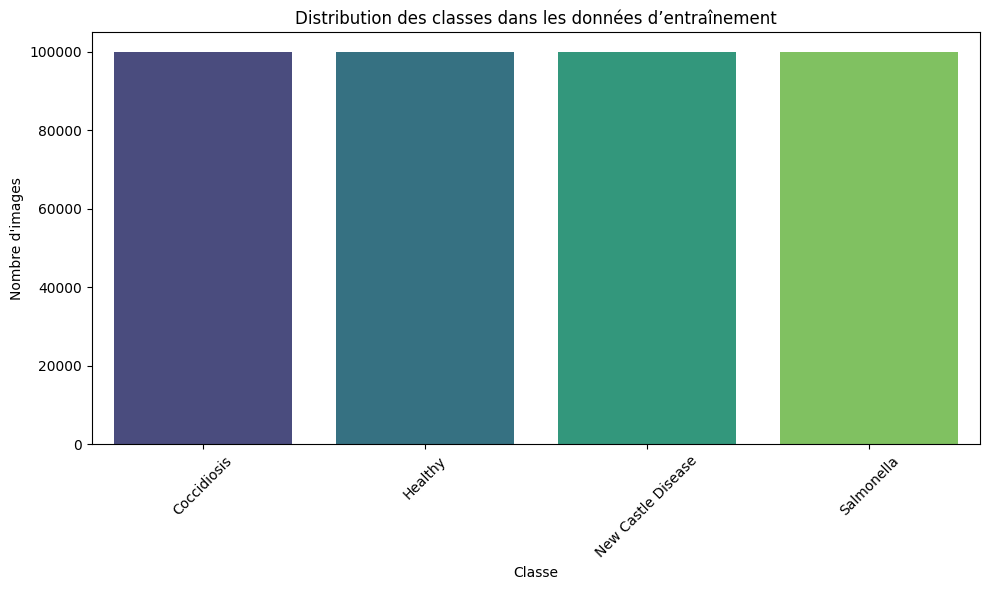

In [ ]:
# train_generator.classes contient les indices de classes (0, 1, 2, ...)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Compter les occurrences
unique_labels, counts = np.unique(train_generator.classes, return_counts=True)

# Mapper les indices vers les noms de classes
label_names = [idx_to_class[idx] for idx in unique_labels]

# Tracer
plt.figure(figsize=(10, 6))
sns.barplot(x=label_names, y=counts, palette='viridis', dodge=False)

plt.title('Distribution des classes dans les données d’entraînement')
plt.ylabel('Nombre d\'images')
plt.xlabel('Classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# first model
# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))

# model.add(Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
# # second model
# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))

# model.add(Conv2D(32, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
# # third model
# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))

# model.add(Conv2D(32, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6,
#     verbose=1
# )


# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model.fit(X_train, y_train, epochs=10,
#           validation_data=(X_test, y_test),
#           callbacks=[early_stopping, lr_scheduler])

In [ ]:
# # fourth model with batch normalization + padding same
# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))

# # 1st conv block
# model.add(Conv2D(32, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# # 2nd conv block
# model.add(Conv2D(64, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.25))

# # dense layers
# model.add(Flatten())
# model.add(Dense(128, kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(4, activation='softmax'))

# # compilation
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # callbacks
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6,
#     verbose=1
# )

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # training
# model.fit(train_ds, epochs=20,
#           validation_data=test_ds,
#           callbacks=[early_stopping, lr_scheduler])

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
# from tensorflow.keras.optimizers import AdamW
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import l2
# import wandb
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# # Input shape
# input_shape = (224, 224, 3)

# # Charger ResNet50 sans top layer ==> Problème avec ce resnet, voir code 2eme notebook
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# inputs = base_model.input

# # Freeze base model
# base_model.trainable = False

# # Custom head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, kernel_regularizer=l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# output = Dense(4, activation='softmax')(x)

# # Build model
# model = Model(inputs=inputs, outputs=output)

# # Compile
# model.compile(optimizer=AdamW(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Callbacks
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# wandb_metrics = WandbMetricsLogger()

# # Entraînement
# model.fit(
#     train_generator,
#     validation_data=test_generator,
#     epochs=40,
#     callbacks=[early_stopping, lr_scheduler, wandb_metrics]
# )


Epoch 1/40
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4951 - loss: 1.2468

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 3019s 481ms/step - accuracy: 0.4951 - loss: 1.2468 - val_accuracy: 0.2736 - val_loss: 3.3096 - learning_rate: 0.0010
Epoch 2/40
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1164s 186ms/step - accuracy: 0.5280 - loss: 1.1664 - val_accuracy: 0.4226 - val_loss: 1.4829 - learning_rate: 0.0010
Epoch 3/40
 421/6250 ━━━━━━━━━━━━━━━━━━━━ 15:08 156ms/step - accuracy: 0.5290 - loss: 1.1710

KeyboardInterrupt: 

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss', 'val_loss']].plot()

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
model.evaluate(test_generator)

In [ ]:
predictions = np.argmax(model.predict(X_test),axis=1)
print(classification_report(np.argmax(y_test, axis=1), predictions, target_names=label_encoder.classes_))

In [ ]:
confusion_matrix(np.argmax(y_test, axis=1),  predictions)

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),  predictions), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)